In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1, sigma0

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
%cd /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/
%cd gfdl.ncrc4-intel16-prod/pp/ocean_monthly
fs=xr.open_dataset('ocean_monthly.static.nc')
deptho=fs['deptho'][:,:]
lon=fs['geolon']; lat=fs['geolat']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
area =fs['areacello']
print(fs)
%cd av/monthly_5yr/

/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf
/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_monthly
<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, x

In [45]:
#CHOOSE WHICH SEASON OR YEARLY, EDIT lentime = #months that it encompasses.

yearly = xr.open_mfdataset(['ocean_monthly.2003-2007.01.nc','ocean_monthly.2003-2007.02.nc','ocean_monthly.2003-2007.03.nc',\
                           'ocean_monthly.2003-2007.04.nc','ocean_monthly.2003-2007.05.nc','ocean_monthly.2003-2007.06.nc',\
                           'ocean_monthly.2003-2007.07.nc','ocean_monthly.2003-2007.08.nc','ocean_monthly.2003-2007.09.nc',\
                           'ocean_monthly.2003-2007.10.nc','ocean_monthly.2003-2007.11.nc','ocean_monthly.2003-2007.12.nc'])

#spring = xr.open_mfdataset(['ocean_monthly.2003-2007.03.nc','ocean_monthly.2003-2007.04.nc','ocean_monthly.2003-2007.05.nc'])
summer = xr.open_mfdataset(['ocean_monthly.2003-2007.06.nc','ocean_monthly.2003-2007.07.nc','ocean_monthly.2003-2007.08.nc'])
#fall   = xr.open_mfdataset(['ocean_monthly.2003-2007.09.nc','ocean_monthly.2003-2007.10.nc','ocean_monthly.2003-2007.11.nc'])
winter = xr.open_mfdataset(['ocean_monthly.2003-2007.12.nc','ocean_monthly.2003-2007.01.nc','ocean_monthly.2003-2007.02.nc'])

lentime= 12; #how many months you are dealing with
fhist  = yearly;

Pressure  = fhist.variables['pso'][:,:,:] #Sea Water Pressure at Sea Water Surface Pa
SST       = fhist.variables['tos'][:,:,:] #tos:long_name = "Sea Surface Temperature" degC
SSS_PSU   = fhist.variables['sos'][:,:,:] #sos:long_name = "Sea Surface Salinity" psu

# Mass flux
mass_in   = fhist.variables['net_massin'][:,:,:]  #all positive
mass_out  = fhist.variables['net_massout'][:,:,:] #all negative
pme_river = mass_in + mass_out #Net Mass flux in kg m-2 s-1, in is positive.
salt_flux_psu = fhist.variables['sfdsi'][:,:,:]*1000.0  #positive salt flux into ocean kg/m2s, ...
#...needs to multiplied by 1000 to convert to psu for consistency with beta

    ## Heat flux components all in W/m2
    #sfc_hflux_from_runoff = fhist.variables['hfrunoffds'][0,:,:] #Heat content (relative to 0C) of liquid+solid runoff into ocean
    #sfc_hflux_coupler     = fhist.variables['net_heat_coupler'][0,:,:] #"Surface ocean heat flux from SW+LW+latent+sensible (via the coupler)"
    #sfc_hflux_pme         = fhist.variables['Heat_PmE'][0,:,:]   #"Heat flux into ocean from mass flux into ocean"
    #frazil_3d_int_z       = fhist.variables['hfsifrazil'][0,:,:] #"Heat Flux into Sea Water due to Frazil Ice Formation"

#The above 4 components should add up to net_surface_heating, 'hfds' diagnostic: 
net_surface_heating   = fhist.variables['hfds'][:,:,:] #"Surface ocean heat flux from SW+LW+latent+sensible+masstransfer+frazil"
#heating_test = sfc_hflux_from_runoff+sfc_hflux_coupler+sfc_hflux_pme+frazil_3d_int_z 
#I checked and heating_test does in fact equal net_surface_heating!


In [46]:
SSS = SA_from_SP(SSS_PSU,Pressure,lon,lat) #absolute salinity g/kg
pot_rho_1 = xr.DataArray(sigma0(SSS, SST)) #potential density referenced to 1000dbar
haline_contraction = beta(SSS, SST, Pressure) #kg/g
salt_transformation_fresh = (haline_contraction*SSS*pme_river) #*31.0 #last integer is days per month
salt_transformation_salt  = haline_contraction*salt_flux_psu
salt_transformation = salt_transformation_salt + salt_transformation_fresh

thermal_expansion = alpha(SSS, SST, Pressure)
heat_transformation =  (thermal_expansion*net_surface_heating) #*days per month?

print('done')
c_p = 3992.1
SURFACE_heat_transf=-heat_transformation/c_p; #units of kg/(s*m2)
SURFACE_salt_transf=-salt_transformation; #units of kg/(s*m2)
#np.nanmean(heat_transformation)

done


In [47]:
isopycnal_bins = np.arange(20,30,.1) ## alter if this density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used

bin_bottoms = isopycnal_bins[:-1]
binned_salt_transformation = (np.zeros((len(bin_bottoms),1080,1440)))
for i in range(len(isopycnal_bins)-1):
    bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
    masked_transform = salt_transformation*np.array(bin_mask)
    masked_transform = xr.DataArray(np.nansum(masked_transform,axis=0))/lentime
    masked_transform = masked_transform.where(masked_transform != 0) 
    binned_salt_transformation[i,:,:] = masked_transform
print('salt_transformation binning done')
    
binned_heat_transformation = (np.zeros((len(bin_bottoms), 1080, 1440)))
for i in range(len(isopycnal_bins)-1):
    bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
    masked_transform = heat_transformation*np.array(bin_mask)
    masked_transform = xr.DataArray(np.nansum(masked_transform,axis=0))/lentime
    masked_transform = masked_transform.where(masked_transform != 0)
    binned_heat_transformation[i,:,:] = masked_transform
print('heat_transformation binning done')



salt_transformation binning done
heat_transformation binning done


In [48]:
salt_transformation = binned_salt_transformation #kg/m2/s
c_p = 3992.1
heat_transformation = binned_heat_transformation/c_p #kg/m2/s
    
isopycnal_bin_diff = np.diff(isopycnal_bins)
salt_transformation = salt_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis] #m/s
heat_transformation = heat_transformation/isopycnal_bin_diff[:,np.newaxis,np.newaxis]
isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2
  
# this procedure defines fluxes from lighter to denser classes as negative, I want the opposite
salt_transformation = salt_transformation *-1
heat_transformation = heat_transformation *-1

net_transformation = heat_transformation + salt_transformation


In [60]:
#Defining a mask to isolate area over which we're computing the transformation:
swmt_final=isopycnal_bins[:-1]*0.0; heat_final=isopycnal_bins[:-1]*0.0; salt_final=isopycnal_bins[:-1]*0.0;
swmt = net_transformation; heat=heat_transformation; salt=salt_transformation;

lowlat=70; highlat=85; lowlon=-0; highlon=60;
depthmask=500;
mask=np.array(area)*0.0+1.0;


#Isolating the Novaya Zemlya
#mask[(lon<60) & (lon>0)]=np.nan; mask[(lon>-290) & (lon<0)]=np.nan;
#mask[(lat<76) | (lat>77.5)]=np.nan; #or operator
#mask[(lon<50) & (lon>0)]=np.nan; mask[(lon>-290) & (lon<0)]=np.nan;
#mask[(lat<70) | (lat>79)]=np.nan; #or operator
#mask[deptho>depthmask]=np.nan; 

# ##Isolating lon and lat:
mask[(lon<lowlon) | (lon>highlon)]=np.nan;
mask[(lat<lowlat) | (lat>highlat)]=np.nan;
mask[deptho>depthmask]=np.nan; 

mask.shape

#Now we want to sum over all lats and lons for a given density bin, mask the ones we don't want

for i in range(len(isopycnal_bins)-1):
    swmt_final[i] = np.nansum(np.nansum(swmt[i,:]*area*mask,axis=1),axis=0)/1e6; #Sv
    heat_final[i] = np.nansum(np.nansum(heat[i,:]*area*mask,axis=1),axis=0)/1e6;
    salt_final[i] = np.nansum(np.nansum(salt[i,:]*area*mask,axis=1),axis=0)/1e6;
    #print(i)

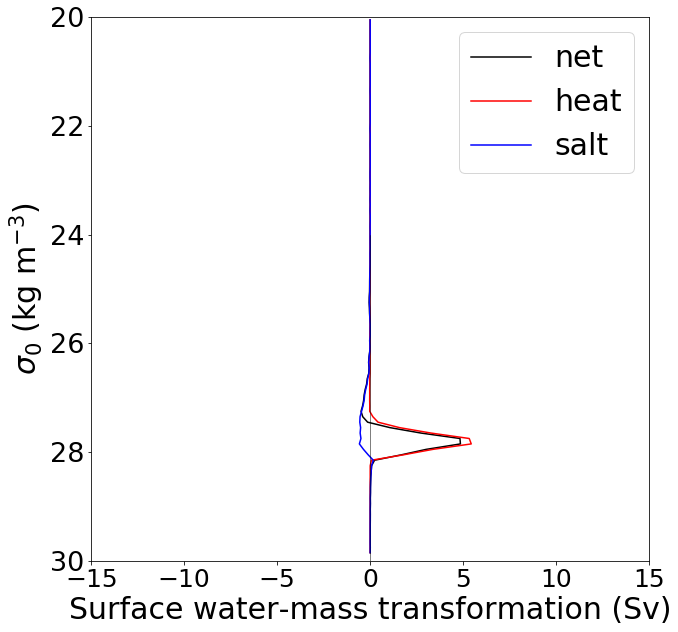

In [61]:
figure = plt.figure(num = 1, figsize = (10,10))
plt.plot(swmt_final,isopycnal_bin_mid,color = 'k',label='net')
plt.plot(heat_final,isopycnal_bin_mid,color = 'r',label='heat')
plt.plot(salt_final,isopycnal_bin_mid,color = 'b',label='salt')
plt.plot([0,0],[24,34],'k',linewidth=0.5)
plt.ylim((30,20)); plt.xlim((-15.,15))
#plt.ylim((34,24)); plt.xlim((-.3,.3))
plt.xticks(fontsize=25); plt.yticks(fontsize=27)
plt.ylabel(r'$\sigma_{0}$ (kg m$^{-3}$)', fontsize = 30)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 30)
plt.legend(loc=1, fontsize = 30)
plt.show()

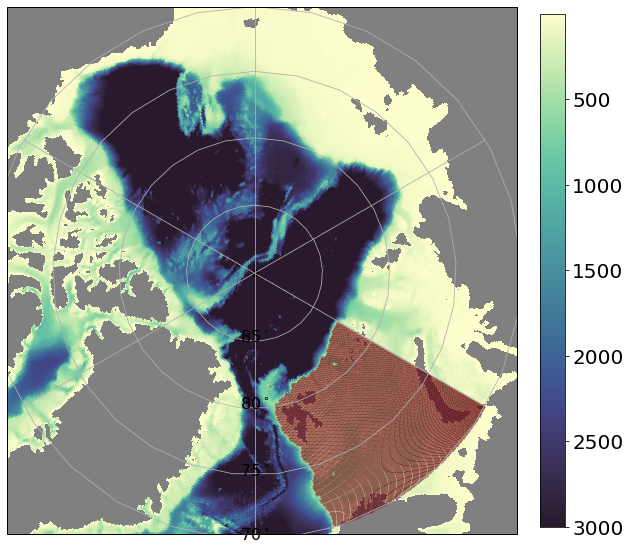

In [62]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,deptho,transform=ccrs.PlateCarree(),cmap=cmocean.cm.deep,vmin=1,vmax=3000);
cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=20); cbar.ax.invert_yaxis()
#ax.set_title('Depth (m)', fontsize=30); 

plt.pcolormesh(lon, lat,(mask),transform=ccrs.PlateCarree(),cmap='Reds',vmin=0,vmax=1,alpha=0.2);



#plt.title('Mask',fontsize=16)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')


In [169]:
max_transformation_index = np.argmax(salt_final)
max_transformation_density = isopycnal_bin_mid[max_transformation_index]
print('Shelf subduction density:',max_transformation_density)
print('Shelf subduction density:',isopycnal_bin_mid[max_transformation_index])
shelf_subduction_plot = np.nansum(net_transformation[max_transformation_index:,:,:]*1e5,axis=0)
shelf_subduction_plot[shelf_subduction_plot==0]=np.nan
shelf_subduction_plot.shape

Shelf subduction density: 32.85000000000012
Shelf subduction density: 32.85000000000012


(1080, 1440)

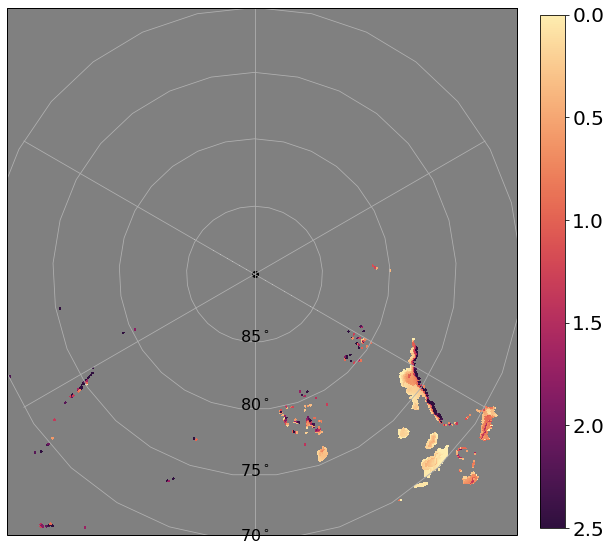

In [170]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,shelf_subduction_plot,transform=ccrs.PlateCarree(),cmap=cmocean.cm.matter,vmin=0,vmax=2.5);
cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=20); cbar.ax.invert_yaxis()
#ax.set_title('Depth (m)', fontsize=30); 

#plt.pcolormesh(lon, lat,(mask),transform=ccrs.PlateCarree(),cmap='Reds',vmin=0,vmax=1,alpha=0.2);



#plt.title('Mask',fontsize=16)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')
